## Download the training data from google drive
https://drive.google.com/file/d/1EQSfJx553yGczcQlYckqw8OfA5ODys0M/view?usp=sharing

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
print(torch.cuda.get_device_name()) 


Tesla T4


In [3]:
!gdown --id '1EQSfJx553yGczcQlYckqw8OfA5ODys0M' --output pineapple.zip
!unzip -q pineapple.zip

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1EQSfJx553yGczcQlYckqw8OfA5ODys0M
To: /content/pineapple.zip
100% 20.1M/20.1M [00:00<00:00, 192MB/s]


## Import library

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
from torchvision.datasets import DatasetFolder, ImageFolder

import matplotlib.pyplot as plt
# This is for the progress bar.
from tqdm.auto import tqdm
import time
import itertools

## Dataset, Dataloader, Transforms

In [5]:
train_tfm = transforms.Compose([
    # TODO: Add data augmentation for training data
    transforms.Resize((224, 224)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.RandomGrayscale(p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation((0,180)),
    transforms.RandomAffine(degrees=(-45, 45), translate=(0, 0.2)),
    transforms.ToTensor(),
    
])

# No need augmentation on validation data
test_tfm = transforms.Compose([
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [6]:
from torch.utils.data.dataset import random_split

# pineapple_set = DatasetFolder("Pineapple_image", loader=lambda x:Image.open(x), extensions='jpg')
pineapple_set = ImageFolder("Pineapple_image", loader=lambda x:Image.open(x))
# Split dataset into training dataset and validation dataset
train_len = int(0.8 * len(pineapple_set))    # train : validation = 9 : 1 
valid_len = len(pineapple_set) - train_len


train_set, valid_set = random_split(pineapple_set, [train_len, valid_len])

#train_aug_set = train_set.copy()

train_set.dataset.transform = train_tfm
valid_set.dataset.transform = test_tfm


In [7]:
# Initial the DataLoader
batch_size = 64

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True)

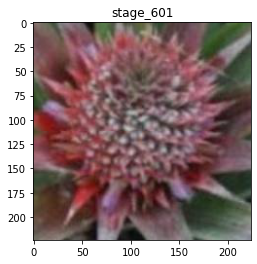

In [8]:
# Test dataloader
label_sets = {
    0 : 'stage_501',
    1 : 'stage_505',
    2 : 'stage_509',
    3 : 'stage_601',
    4 : 'stage_605',
    5 : 'stage_609',
    6 : 'stage_701',
    7 : 'stage_705',
    8 : 'stage_709'
}
img, label = next(iter(train_loader))
img = transforms.ToPILImage()(img[0]).convert('RGB')
plt.title(label_sets[int(label[0])])
plt.imshow(img)


## Training model

In [9]:
class Classifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.cnn_layers = nn.Sequential(
        # Input shape[3, 224, 224]
        # TODO: CNN layers
        #nn.Conv2d(input, output, kernelsize, stride, padding)
        nn.Conv2d(3, 64, 3, 1, 1),#output shape(64, 224, 224 )
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2, 2, 0),#output shape(64, 112, 112 )

        nn.Conv2d(64, 128, 3, 1, 1),#output shape(128, 112, 112 )
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(2, 2, 0),#output shape(128, 56, 56 )

        nn.Conv2d(128, 256, 3, 1, 1),#output shape(256, 56 56 )
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(2, 2, 0),#output shape(256, 28, 28 )

        nn.Conv2d(256,256, 3, 1, 1),#output shape(128, 28, 28 ),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(2, 2, 0),#output shape(256, 14, 14 )

        nn.Conv2d(256,512, 3, 1, 1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.MaxPool2d(2, 2, 0),#output shape(512, 7, 7 )

    )

    self.fc_layers = nn.Sequential(
        # TODO: Fully connected layer
        nn.Linear(512 * 7 * 7, 256),
        torch.nn.Dropout(0.4),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, 9),
    )
    
  def forward(self, x):
    x = self.cnn_layers(x)

    # The extracted feature map must be flatten before going to fully-connected layers.
    x = torch.flatten(x, 1)

    x = self.fc_layers(x)
    return x

## Training

In [10]:
torch.cuda.empty_cache()
# Set the random seed.
seed = 0
torch.manual_seed(seed)
if(torch.cuda.is_available()):
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

# "cuda" only when GPUs are available.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

# Initialize a model, and put it on the device specified.
model = Classifier().to(device)
model.device = device

# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=0.0001)

# The number of training epochs.
epoch_num = 60

# Initialize learning rate scheduler
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.97)

valid_acc = 0.0
train_acc_history = []
train_loss_history = []
valid_acc_history = []
valid_loss_history = []
for epoch in range(epoch_num):
  model.train()
  # These are used to record information in training.
  train_loss = []
  train_accs = []

  for batch in tqdm(train_loader):

    imgs, labels = batch

    # Forward the data. (Make sure data and model are on the same device.)
    logits = model(imgs.to(device))

    # Calculate the cross-entropy loss.
    # We don't need to apply softmax before computing cross-entropy as it is done automatically.
    loss = criterion(logits, labels.to(device))

    # Gradients stored in the parameters in the previous step should be cleared out first.
    optimizer.zero_grad()

    # Compute the gradients for parameters.
    loss.backward()

    # Clip the gradient norms for stable training.
    grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

    # Update the parameters with computed gradients.
    optimizer.step()

    # Compute the accuracy for current batch.
    acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

    # Record the loss and accuracy.
    train_loss.append(loss.item())
    train_accs.append(acc.item())
  
  # The average loss and accuracy of the training set is the average of the recorded values.
  scheduler.step()
  train_loss = sum(train_loss) / len(train_loss)
  train_accs = sum(train_accs) / len(train_accs)
  train_acc_history.append(train_accs)
  train_loss_history.append(train_loss)
  
  # Print the information.
  print(f"[ Train | {epoch + 1:03d}/{epoch_num:03d} ] loss = {train_loss:.5f}, acc = {acc:.5f}")

  # ---------- Validation ----------
  # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
  model.eval()

  # These are used to record information in validation.
  
  # Iterate the validation set by batches.
  # for batch in tqdm(valid_loader):

  #     # A batch consists of image data and corresponding labels.
  #     imgs, labels = batch

  #     # We don't need gradient in validation.
  #     # Using torch.no_grad() accelerates the forward process.
  #     with torch.no_grad():
  #       logits = model(imgs.to(device))
  #       y_pred.append(logits)
  #     # We can still compute the loss (but not the gradient).
  #     y_test.append(labels.to(device))
  #     loss = criterion(logits, labels.to(device))

  #     # Compute the accuracy for current batch.
  #     acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

  #     # Record the loss and accuracy.
  #     valid_loss.append(loss.item())
  #     valid_accs.append(acc)
  valid_loss = []
  valid_accs = []
  y_pred = []
  y_test = []
  def validate(valid_loader, model, criterion, device, y_pred, y_test):
    model.eval()
    
    with torch.no_grad():
        end = time.time()
        for i, (images, labels) in enumerate(valid_loader):
            # if device.gpu is not None:
            #     images = images.cuda(device.gpu, non_blocking=True)
            # if torch.cuda.is_available():
            #     target = target.cuda(device.gpu, non_blocking=True)
            #inputs, labels = data                         # this is what you had
            images, labels = images.cuda(), labels.cuda() # add this line 
            output = model(images)
            _, preds = torch.max(output, 1)                            # preds是預測結果
            loss = criterion(output, labels)
            acc = (output.argmax(dim=-1) == labels.to(device)).float().mean()
            
            y_pred.extend(preds.view(-1).detach().cpu().numpy())       # 將preds預測結果detach出來，並轉成numpy格式       
            y_test.extend(labels.view(-1).detach().cpu().numpy())      # target是ground-truth的label
            valid_loss.append(loss.item())
            valid_accs.append(acc.item())
            
        
    return y_pred, y_test ,valid_loss, valid_accs


  y_pred, y_test, valid_loss, valid_accs = validate(valid_loader, model, criterion, device,  y_pred, y_test)

  # The average loss and accuracy for entire validation set is the average of the recorded values.
  valid_loss = sum(valid_loss) / len(valid_loss)
  valid_acc = sum(valid_accs) / len(valid_accs)
  valid_acc_history.append(valid_acc)
  valid_loss_history.append(valid_loss)

  # Print the information.
  print(f"[ Valid | {epoch + 1:03d}/{epoch_num:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


cuda


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 001/060 ] loss = 1.99965, acc = 0.37500
[ Valid | 001/060 ] loss = 2.30130, acc = 0.12031


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 002/060 ] loss = 1.33438, acc = 0.62500
[ Valid | 002/060 ] loss = 2.01720, acc = 0.29063


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 003/060 ] loss = 0.92804, acc = 0.68750
[ Valid | 003/060 ] loss = 0.92523, acc = 0.67292


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 004/060 ] loss = 0.73371, acc = 0.78125
[ Valid | 004/060 ] loss = 3.93174, acc = 0.35417


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 005/060 ] loss = 0.70978, acc = 0.65625
[ Valid | 005/060 ] loss = 0.76070, acc = 0.73021


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 006/060 ] loss = 0.50130, acc = 0.75000
[ Valid | 006/060 ] loss = 0.59335, acc = 0.79375


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 007/060 ] loss = 0.47870, acc = 0.84375
[ Valid | 007/060 ] loss = 0.48518, acc = 0.82188


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 008/060 ] loss = 0.47500, acc = 0.78125
[ Valid | 008/060 ] loss = 0.55756, acc = 0.81927


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 009/060 ] loss = 0.40427, acc = 0.84375
[ Valid | 009/060 ] loss = 0.35080, acc = 0.86563


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 010/060 ] loss = 0.36177, acc = 0.84375
[ Valid | 010/060 ] loss = 0.41516, acc = 0.86250


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 011/060 ] loss = 0.27911, acc = 0.96875
[ Valid | 011/060 ] loss = 0.72750, acc = 0.76562


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 012/060 ] loss = 0.26731, acc = 0.81250
[ Valid | 012/060 ] loss = 0.33468, acc = 0.89635


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 013/060 ] loss = 0.25959, acc = 0.93750
[ Valid | 013/060 ] loss = 0.34817, acc = 0.90104


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 014/060 ] loss = 0.29325, acc = 0.93750
[ Valid | 014/060 ] loss = 0.36036, acc = 0.85313


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 015/060 ] loss = 0.24141, acc = 0.96875
[ Valid | 015/060 ] loss = 0.29836, acc = 0.90417


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 016/060 ] loss = 0.18616, acc = 1.00000
[ Valid | 016/060 ] loss = 0.27707, acc = 0.89844


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 017/060 ] loss = 0.17789, acc = 0.93750
[ Valid | 017/060 ] loss = 0.60466, acc = 0.81667


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 018/060 ] loss = 0.16471, acc = 0.87500
[ Valid | 018/060 ] loss = 0.24041, acc = 0.92500


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 019/060 ] loss = 0.12441, acc = 0.93750
[ Valid | 019/060 ] loss = 0.25422, acc = 0.91042


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 020/060 ] loss = 0.12814, acc = 0.93750
[ Valid | 020/060 ] loss = 0.24007, acc = 0.91615


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 021/060 ] loss = 0.11589, acc = 0.90625
[ Valid | 021/060 ] loss = 0.39664, acc = 0.89219


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 022/060 ] loss = 0.10285, acc = 1.00000
[ Valid | 022/060 ] loss = 0.39012, acc = 0.87500


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 023/060 ] loss = 0.09944, acc = 0.96875
[ Valid | 023/060 ] loss = 0.22684, acc = 0.92604


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 024/060 ] loss = 0.07258, acc = 0.93750
[ Valid | 024/060 ] loss = 0.19814, acc = 0.93594


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 025/060 ] loss = 0.05958, acc = 1.00000
[ Valid | 025/060 ] loss = 0.46961, acc = 0.86250


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 026/060 ] loss = 0.07536, acc = 1.00000
[ Valid | 026/060 ] loss = 0.26980, acc = 0.91510


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 027/060 ] loss = 0.07192, acc = 0.96875
[ Valid | 027/060 ] loss = 0.23359, acc = 0.92552


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 028/060 ] loss = 0.06219, acc = 1.00000
[ Valid | 028/060 ] loss = 0.23410, acc = 0.92656


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 029/060 ] loss = 0.05140, acc = 1.00000
[ Valid | 029/060 ] loss = 0.23423, acc = 0.93073


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 030/060 ] loss = 0.05725, acc = 0.96875
[ Valid | 030/060 ] loss = 0.30627, acc = 0.90417


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 031/060 ] loss = 0.05964, acc = 0.96875
[ Valid | 031/060 ] loss = 0.31255, acc = 0.90365


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 032/060 ] loss = 0.05579, acc = 0.93750
[ Valid | 032/060 ] loss = 0.20971, acc = 0.93958


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 033/060 ] loss = 0.04815, acc = 1.00000
[ Valid | 033/060 ] loss = 0.33234, acc = 0.90365


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 034/060 ] loss = 0.02967, acc = 0.96875
[ Valid | 034/060 ] loss = 0.23299, acc = 0.93125


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 035/060 ] loss = 0.03492, acc = 0.96875
[ Valid | 035/060 ] loss = 0.21618, acc = 0.93385


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 036/060 ] loss = 0.02417, acc = 1.00000
[ Valid | 036/060 ] loss = 0.22088, acc = 0.93854


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 037/060 ] loss = 0.02844, acc = 1.00000
[ Valid | 037/060 ] loss = 0.24892, acc = 0.93542


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 038/060 ] loss = 0.02658, acc = 1.00000
[ Valid | 038/060 ] loss = 0.23510, acc = 0.94427


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 039/060 ] loss = 0.01790, acc = 1.00000
[ Valid | 039/060 ] loss = 0.21745, acc = 0.94583


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 040/060 ] loss = 0.02050, acc = 1.00000
[ Valid | 040/060 ] loss = 0.22248, acc = 0.93437


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 041/060 ] loss = 0.02665, acc = 1.00000
[ Valid | 041/060 ] loss = 0.34817, acc = 0.91875


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 042/060 ] loss = 0.01320, acc = 1.00000
[ Valid | 042/060 ] loss = 0.22759, acc = 0.94479


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 043/060 ] loss = 0.01733, acc = 0.96875
[ Valid | 043/060 ] loss = 0.20975, acc = 0.94740


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 044/060 ] loss = 0.01839, acc = 1.00000
[ Valid | 044/060 ] loss = 0.19019, acc = 0.94635


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 045/060 ] loss = 0.01864, acc = 1.00000
[ Valid | 045/060 ] loss = 0.22553, acc = 0.93802


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 046/060 ] loss = 0.01364, acc = 1.00000
[ Valid | 046/060 ] loss = 0.25192, acc = 0.93333


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 047/060 ] loss = 0.01383, acc = 0.96875
[ Valid | 047/060 ] loss = 0.24041, acc = 0.94063


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 048/060 ] loss = 0.01372, acc = 1.00000
[ Valid | 048/060 ] loss = 0.22747, acc = 0.94479


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 049/060 ] loss = 0.01949, acc = 1.00000
[ Valid | 049/060 ] loss = 0.20882, acc = 0.94792


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 050/060 ] loss = 0.01247, acc = 1.00000
[ Valid | 050/060 ] loss = 0.21154, acc = 0.94219


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 051/060 ] loss = 0.00988, acc = 1.00000
[ Valid | 051/060 ] loss = 0.23948, acc = 0.95000


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 052/060 ] loss = 0.01030, acc = 1.00000
[ Valid | 052/060 ] loss = 0.23330, acc = 0.93594


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 053/060 ] loss = 0.01104, acc = 1.00000
[ Valid | 053/060 ] loss = 0.28582, acc = 0.92344


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 054/060 ] loss = 0.01018, acc = 1.00000
[ Valid | 054/060 ] loss = 0.25135, acc = 0.94167


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 055/060 ] loss = 0.01752, acc = 1.00000
[ Valid | 055/060 ] loss = 0.29028, acc = 0.93333


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 056/060 ] loss = 0.01436, acc = 1.00000
[ Valid | 056/060 ] loss = 0.23328, acc = 0.94635


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 057/060 ] loss = 0.01342, acc = 1.00000
[ Valid | 057/060 ] loss = 0.29664, acc = 0.91771


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 058/060 ] loss = 0.01144, acc = 1.00000
[ Valid | 058/060 ] loss = 0.23397, acc = 0.93333


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 059/060 ] loss = 0.01375, acc = 1.00000
[ Valid | 059/060 ] loss = 0.20740, acc = 0.94531


  0%|          | 0/23 [00:00<?, ?it/s]

[ Train | 060/060 ] loss = 0.00958, acc = 1.00000
[ Valid | 060/060 ] loss = 0.23436, acc = 0.95417


In [11]:
# Save the model
torch.save(model, "mymodel.pth")


In [12]:
# util functions
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        # print("Normalized confusion matrix")
    else:
      pass
        # print('Confusion matrix, without normalization')

    # print(cm)
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Text(0.5, 0, 'epoch')

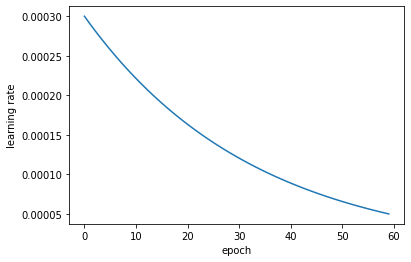

In [13]:
learning_rate=[]
for i in range(60):
  learning_rate.append(0.0003*0.97**i)
plt.plot(learning_rate)
plt.ylabel('learning rate')
plt.xlabel('epoch')

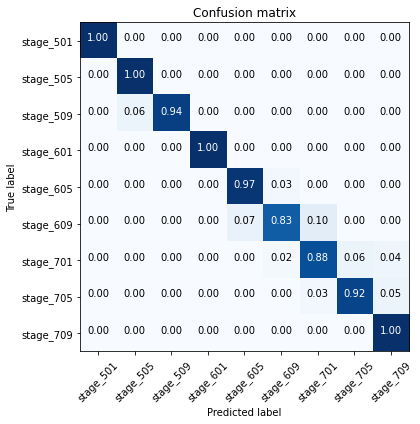

In [14]:
from sklearn.metrics import confusion_matrix

classes = ['stage_501',
    'stage_505',
    'stage_509',
    'stage_601',
    'stage_605',
    'stage_609',
    'stage_701',
    'stage_705',
    'stage_709']
matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(matrix, classes=classes, normalize=True)


In [15]:
import matplotlib.pyplot as plt
def show_train_history(train_acc,valid_acc,ylabel):
    epoch = np.linspace(1,60,60)
    plt.plot(epoch, train_acc)
    plt.plot(epoch, valid_acc)
    plt.title('Train History')
    plt.ylabel(ylabel)
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

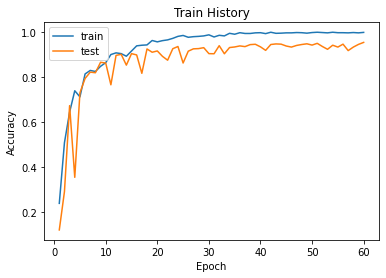

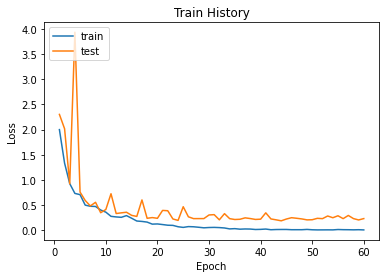

In [16]:


show_train_history(train_acc_history,valid_acc_history,'Accuracy')
show_train_history(train_loss_history,valid_loss_history,'Loss')